In [1]:
%reset -f

In [2]:
import plotting
from pyseis.wave_equations import elastic_isotropic, acoustic_isotropic
from pyseis.wavelets.elastic import Elastic2D
from pyseis.wavelets.acoustic import Acoustic2D
from pyseis import inversion
%matplotlib inline

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [3]:
import os
import math
pwd = os.getcwd()
%env DATAPATH={pwd}/wrk/

env: DATAPATH=/home/test01/App/01_PySeis/xu/TASK6_DAS_DATA/Data/ForwardModeling/wrk/


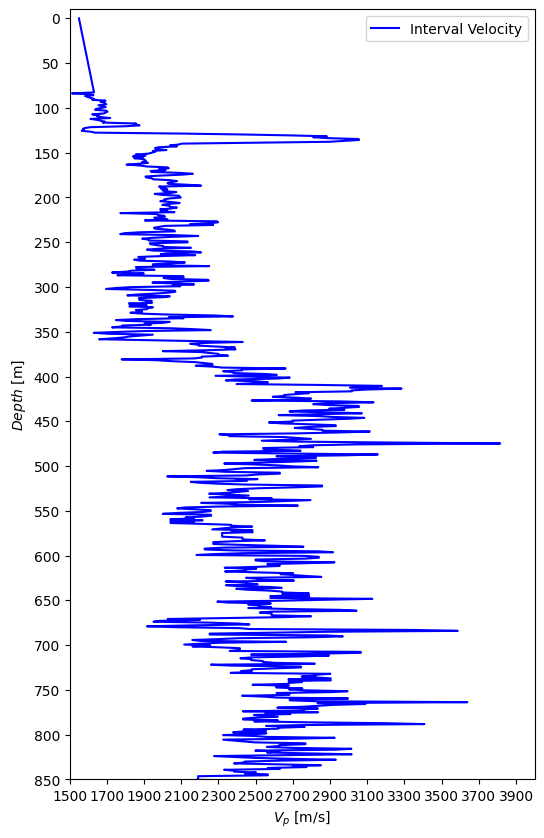

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the log data from the CSV file in the current directory
file_path = 'Curtin_DAS_VSP_Sonic_modified.csv'  # CSV file in the current folder
df = pd.read_csv(file_path)

# Extract depth and interval velocity from the loaded data
depths = df['Depth (DAS)'].values
interval_velocities = df['interval velocity'].values

# Plot settings
depmin, depmax, depstep = -10, 850, 50
vmin, vmax, vstep = 1500, 4000, 200

# Plotting the data
fig = plt.figure(figsize=(6, 10))
ax1 = fig.add_subplot(1,1,1)

# Plot interval velocities (original only, no interpolation)
ax1.plot(interval_velocities, depths, lw=1.5, color='blue', label='Interval Velocity')

# Label and format the plot
ax1.set_xlabel('$V_p$ [m/s]')
ax1.set_ylabel('$Depth$ [m]')
ax1.set_xlim(vmin, vmax)
ax1.set_ylim(depmax, depmin)  # depth increases downward
ax1.set_xticks(np.arange(vmin, vmax, vstep))
ax1.set_yticks(np.arange(depmax, depmin, -depstep))
ax1.legend()

plt.show()


In [21]:
# import numpy as np
# import matplotlib.pyplot as plt

# # depth (m) and velocity (m/s) from your sonic log
# depth = depths
# vel = interval_velocities

# # cumulative one-way vertical time
# dz = np.diff(depth)
# v_mid = (vel[:-1] + vel[1:]) / 2.0
# t_vert = np.concatenate([[0], np.cumsum(dz / v_mid)])

# # average velocity to each depth
# v_avg = depth / (t_vert + 1e-9)   # avoid div by zero at surface

# # --- source geometry ---
# x_src = 334.22   # horizontal offset in m (example)
# z_src = 0.0     # source depth in m (0 = surface)

# # compute first breaks
# first_breaks_time = []
# for zr, vav in zip(depth, v_avg):
#     L = np.sqrt(x_src**2 + (zr - z_src)**2)   # straight-line path
#     t = L / vav
#     first_breaks_time.append(t)

# first_breaks_time = np.array(first_breaks_time)

# # convert to sample indices
# dt = 0.001
# first_breaks_idx = (first_breaks_time / dt).astype(int)

# # --- plot ---
# plt.figure(figsize=(8,6))
# plt.plot(depth, first_breaks_time, 'r-', lw=2, label=f"First breaks (offset={x_src} m)")
# plt.gca().invert_yaxis()
# plt.xlabel("Depth (m)")
# plt.ylabel("First-break time (s)")
# plt.title("Synthetic first breaks with source offset")
# plt.grid(True); plt.legend()
# plt.show()


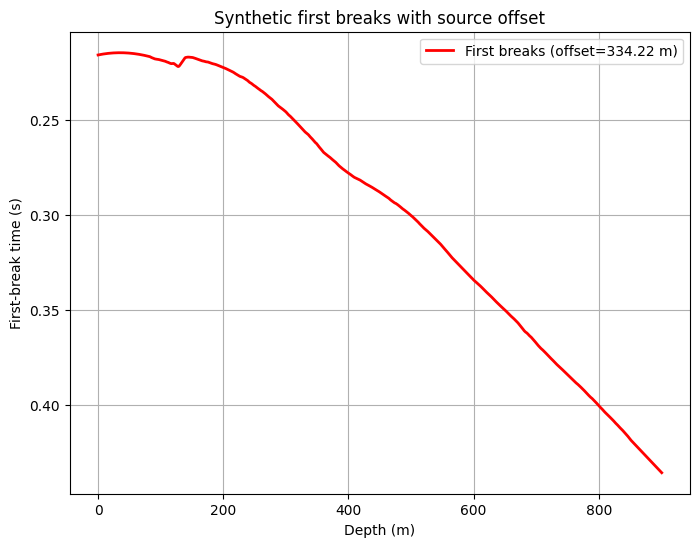

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# depth (m) and velocity (m/s) from your sonic log
depth = depths
vel = interval_velocities

# cumulative one-way vertical time
dz = np.diff(depth)
v_mid = (vel[:-1] + vel[1:]) / 2.0
t_vert = np.concatenate([[0], np.cumsum(dz / v_mid)])

# average velocity to each depth
v_avg = depth / (t_vert + 1e-9)

# --- source geometry ---
x_src = 334.22   # horizontal offset in m
z_src = 0.0      # source depth (surface)

# compute first breaks
first_breaks_time = []
for zr, vav in zip(depth, v_avg):
    L = np.sqrt(x_src**2 + (zr - z_src)**2)
    if zr == 0:   # surface point → assign Trace 1 value
        t = L / vel[0]   # use the first log velocity
    else:
        t = L / vav
    first_breaks_time.append(t)

first_breaks_time = np.array(first_breaks_time)

# convert to sample indices
dt = 0.001
first_breaks_idx = (first_breaks_time / dt).astype(int)

# --- plot ---
plt.figure(figsize=(8,6))
plt.plot(depth, first_breaks_time, 'r-', lw=2, label=f"First breaks (offset={x_src} m)")
plt.gca().invert_yaxis()
plt.xlabel("Depth (m)")
plt.ylabel("First-break time (s)")
plt.title("Synthetic first breaks with source offset")
plt.grid(True); plt.legend()
plt.show()


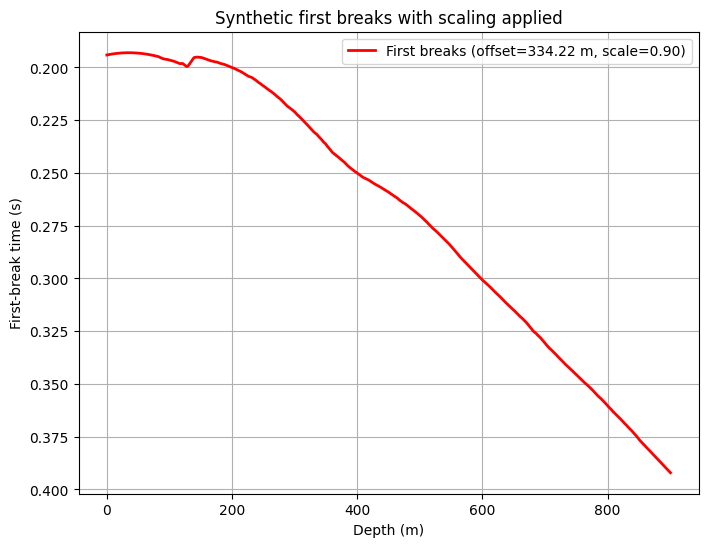

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# depth (m) and velocity (m/s) from your sonic log
depth = depths
vel = interval_velocities

# cumulative one-way vertical time
dz = np.diff(depth)
v_mid = (vel[:-1] + vel[1:]) / 2.0
t_vert = np.concatenate([[0], np.cumsum(dz / v_mid)])

# average velocity to each depth
v_avg = depth / (t_vert + 1e-9)

# --- source geometry ---
x_src = 334.22   # horizontal offset in m
z_src = 0.0      # source depth (surface)

# compute first breaks
first_breaks_time = []
for zr, vav in zip(depth, v_avg):
    L = np.sqrt(x_src**2 + (zr - z_src)**2)
    if zr == 0:   # surface point → assign Trace 1 value
        t = L / vel[0]   # use the first log velocity
    else:
        t = L / vav
    first_breaks_time.append(t)

first_breaks_time = np.array(first_breaks_time)

# --- apply scale factor ---
scale = 0.9  # <--- adjust this value (e.g., 1.0 = no scale, 1.05 = +5%)
first_breaks_time_scaled = scale * first_breaks_time

# convert to sample indices
dt = 0.001
first_breaks_idx = (first_breaks_time_scaled / dt).astype(int)

# --- plot ---
plt.figure(figsize=(8,6))
plt.plot(depth, first_breaks_time_scaled, 'r-', lw=2, 
         label=f"First breaks (offset={x_src} m, scale={scale:.2f})")
plt.gca().invert_yaxis()
plt.xlabel("Depth (m)")
plt.ylabel("First-break time (s)")
plt.title("Synthetic first breaks with scaling applied")
plt.grid(True); plt.legend()
plt.show()


In [35]:
import pandas as pd

# Create a DataFrame with depth and scaled first-break time
df_first_picks = pd.DataFrame({
    "Depth (m)": depth,
    "First-break time (s)": first_breaks_time_scaled
})

# Show the first few rows
print(df_first_picks.head())

# Save to CSV
df_first_picks.to_csv("first_picks_run4.csv", index=False)



   Depth (m)  First-break time (s)
0      0.000              0.194063
1      1.021              0.194002
2      2.042              0.193942
3      3.063              0.193884
4      4.084              0.193828
